In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd 
from pathlib import Path
from bioblp.data import COL_EDGE, COL_SOURCE, COL_TARGET

/home/jovyan/.conda/envs/bioblp-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_DIR = Path("../data")
SHARED_DIR = Path("/home/jovyan/workbench-shared-folder/bioblp")

In [4]:
!ls {SHARED_DIR}/models

1baon0eg  iwy9z7m9


## Load benchmark

In [5]:
dpi_benchmark_path = SHARED_DIR.joinpath('data/benchmarks/dpi_fda.tsv') 

In [6]:
dpi_bm = pd.read_csv(dpi_benchmark_path, sep='\t', names=[COL_SOURCE, COL_EDGE, COL_TARGET])
dpi_bm.head(3)

,src,edg,tgt
0,DB01079,DPI,Q13639
1,DB00114,DPI,P20711
2,DB01158,DPI,P13637



* [DB01079; Tegaserod](https://go.drugbank.com/drugs/DB01079)
Tegaserod is a serotonin-4 (5-HT4) receptor agonist indicated for the treatment of constipation predominant irritable bowel syndrome (IBS-C) specifically in women under the age of 65. There is currently no safety or efficacy data for use of tegaserol in men.

* https://www.uniprot.org/uniprotkb/Q13639/entry

In [7]:
dpi_drugs_unique = list(dpi_bm.src.unique())
dpi_prots_unique = list(dpi_bm.tgt.unique())
print(f'# total dpi instances (TP): {len(dpi_bm)}')
print(f'# Unique Drugs: {len(dpi_drugs_unique)}')
print(f'# Unique Proteins: {len(dpi_prots_unique)}')


# total dpi instances (TP): 19161
# Unique Drugs: 2286
# Unique Proteins: 2705


## Prepare Data for ML

In [9]:
from bioblp.benchmarking.featurize import load_model_and_entity_to_id_maps, ENTITY_TO_ID_MAP, RELATION_TO_ID_MAP

In [10]:
model_dir = SHARED_DIR.joinpath('models/1baon0eg')
model_dir_best = SHARED_DIR.joinpath('models/iwy9z7m9')
kge_artifacts = load_model_and_entity_to_id_maps(model_dir)
entity_to_id_map = kge_artifacts.get(ENTITY_TO_ID_MAP)
relation_to_id_map = kge_artifacts.get(RELATION_TO_ID_MAP)


21:29:17 - INFO - bioblp.benchmarking.featurize - Loading trained model from /home/jovyan/workbench-shared-folder/bioblp/models/1baon0eg


In [11]:
type(entity_to_id_map)

dict

### Generate Negative samples

In [208]:
from bioblp.benchmarking.preprocess import prepare_dpi_samples

In [213]:
import numpy as np
dpi_bm = pd.read_csv(dpi_benchmark_path, sep='\t', names=[COL_SOURCE, COL_EDGE, COL_TARGET])
dpi_bm['src_id'] = dpi_bm['src'].map(lambda x: entity_to_id_map.get(x, np.nan))
dpi_bm['tgt_id'] = dpi_bm['tgt'].map(lambda x: entity_to_id_map.get(x, np.nan))

In [210]:
dpi_bm[dpi_bm.src_id.isnull() | dpi_bm.tgt_id.isnull()]

,src,edg,tgt,src_id,tgt_id


In [214]:
dpi_bm_transd = dpi_bm[~(dpi_bm.src_id.isnull() | dpi_bm.tgt_id.isnull())]

In [215]:
from copy import deepcopy
dpi_bm_transd_copy = dpi_bm_transd

In [216]:
len(dpi_bm_transd) -len(dpi_bm)

-483

In [218]:
pos_neg_df = prepare_dpi_samples(dpi_bm_transd_copy, entity_to_id_map, relation_to_id_map)

In [219]:
len(pos_neg_df)

37356

In [221]:
pos_neg_df.head(3)

,src,edg,tgt,src_id,tgt_id,label
0,8879,5,44406,8861.0,44147.0,1
1,7928,5,30725,7916.0,30505.0,1
2,8957,5,29310,8938.0,29091.0,1


### Featurize by obtaining joint entity pair encoding

In [222]:
from bioblp.benchmarking.featurize import generate_entity_pair_joint_encoding
from bioblp.benchmarking.featurize import concatenate, average


In [223]:
# pass on to KGEM encoder to featurize each entity pair
encoded_df = generate_entity_pair_joint_encoding(pos_neg_df,
                                    model=kge_artifacts["model"],
                                    transform_fn=concatenate)

encoded_df['joint_encoding'] = encoded_df['joint_encoding'].apply(lambda x: np.asarray(x))#.reshape(1, -1))


14:54:17 - INFO - bioblp.benchmarking.featurize - Applying transformation function: f<function concatenate at 0x7f26fa145940>, to retrieve joint encoding for entity pair


In [224]:
len(encoded_df)

37356

## Train ML model for binary clf

In [225]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [226]:
x_train, x_test, y_train, y_test = train_test_split(np.stack(encoded_df.joint_encoding), encoded_df.label, test_size=0.1, 
                                                    random_state=0, shuffle=True)

In [195]:
lr2 = LogisticRegression(max_iter=300)
lr2.fit(x_train, y_train)

LogisticRegression(max_iter=300)

In [227]:
lr = LogisticRegression(max_iter=300)
lr.fit(x_train, y_train)

LogisticRegression(max_iter=300)

In [228]:
# predictions
y_testpred = lr.predict(x_test)

In [229]:
# score
# Use score method to get accuracy of model
insample_acc= lr.score(x_train, y_train)
test_acc = lr.score(x_test, y_test)
print(f"Insample accuracy: {insample_acc}")
print(f"Test accuracy: {test_acc}")

Insample accuracy: 0.6802498512790006
Test accuracy: 0.6464132762312634


In [197]:
# score
# Use score method to get accuracy of model
insample_acc= lr2.score(x_train, y_train)
test_acc = lr2.score(x_test, y_test)
print(f"Insample accuracy: {insample_acc}")
print(f"Test accuracy: {test_acc}")

Insample accuracy: 0.9168947055324211
Test accuracy: 0.903372591006424


#### confusion matrix

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [206]:
metrics.classification_report(y_test, y_testpred)

'              precision    recall  f1-score   support\n\n           0       0.91      0.89      0.90      1879\n           1       0.89      0.91      0.90      1857\n\n    accuracy                           0.90      3736\n   macro avg       0.90      0.90      0.90      3736\nweighted avg       0.90      0.90      0.90      3736\n'

In [231]:
print(metrics.classification_report(y_test, y_testpred))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64      1879
           1       0.64      0.67      0.65      1857

    accuracy                           0.65      3736
   macro avg       0.65      0.65      0.65      3736
weighted avg       0.65      0.65      0.65      3736



In [233]:
cm = metrics.confusion_matrix(y_test, y_testpred)
print(cm)

[[1171  708]
 [ 613 1244]]


In [200]:
cm_best = metrics.confusion_matrix(y_test, y_testpred)
print(cm_best)

[[1676  203]
 [ 158 1699]]


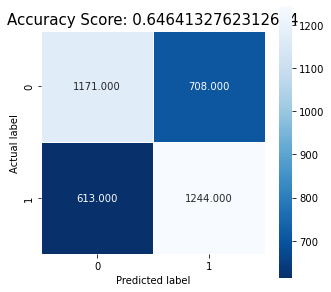

In [234]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_acc)
plt.title(all_sample_title, size = 15);

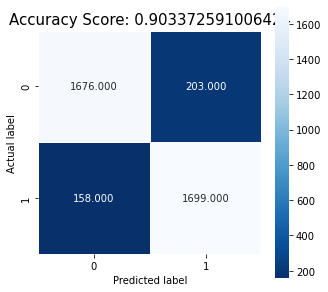

In [203]:
plt.figure(figsize=(5,5))
sns.heatmap(cm_best, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_acc)
plt.title(all_sample_title, size = 15);

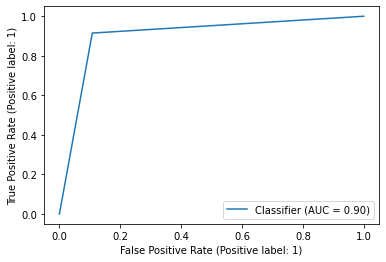

In [204]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_testpred)
plt.show()

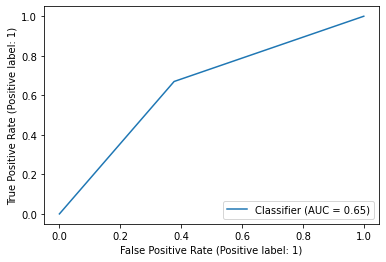

In [235]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_test, y_testpred)
plt.show()

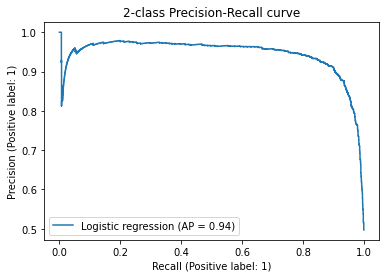

In [205]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr2, x_test, y_test, name="Logistic regression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

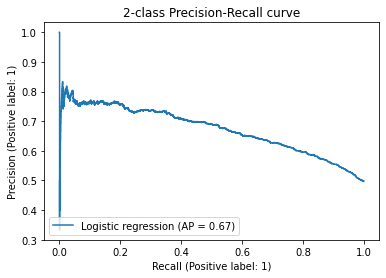

In [236]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    lr, x_test, y_test, name="Logistic regression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")